In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `/mnt/064AC6424AC62E6D/git_workspace/16715/hopper-sim/scripts/Project.toml`


In [2]:
using RigidBodyDynamics
using LinearAlgebra
using MeshCatMechanisms
using MeshCat
using StaticArrays

WebIO._IJuliaInit()

In [3]:
# Assume links do have mass
# Inertia terms are taken w.r.t. CoM of links

# link lengths
const l0 = 0.1
const l1 = 0.3
const l2 = 0.3
const l3 = 0.1
const l4 = 0.2
const l5 = 0.0205
const lee = sqrt((l3 + l4)^2 + l5^2)

# CoM locations
const l_c0x = 0.0125108364230515
const l_c0y = 0.00117191218927888
const l_c0 = sqrt(l_c0x^2 + l_c0y^2)
const alpha0 = atan(l_c0y, l_c0x)

const l_c1 = 0.149359714867044

const l_c2 = 0.0469412900551914

const l_ceex = 0.113177000131857
const l_ceey = -0.015332867880069
const l_cee = sqrt(l_ceex^2 + l_ceey^2)
const alpha3 = atan(l_ceey, l_ceex)
const alphaee = atan(l5, l3+l4)

# link masses
const m0 = 0.24644240965487
const m1 = 0.0707939028219395
const m2 = 0.276735496985514
const m3 = 0.130824780046739

const g = 9.807

# mass moment of inertia in axis of rotation
const I0 = 0.000172067745507247  # iyy
const I1 = 0.000147960574744097
const I2 = 0.000302324068012293
const I3 = 0.000164188445564489

0.000164188445564489

In [4]:
world = RigidBody{Float64}("world")
doublependulum = Mechanism(world; gravity = SVector(0, 0, g))

Spanning tree:
Vertex: world (root)
No non-tree joints.

In [5]:
curdir = pwd()
urdfpath = joinpath(curdir, "../res/flyhopper_robot/urdf/flyhopper_robot.urdf")
doublependulum = parse_urdf(urdfpath, floating=false)
state = MechanismState(doublependulum)

MechanismState{Float64, Float64, Float64, …}(…)

In [6]:
function f_1(x)
    # parallel mechanism dynamics
    q0 = x[1]
    q0d = x[2]
    q1 = x[3]
    q1d = x[4]
    q2 = x[5]
    q2d = x[6]
    q3 = x[7]
    q3d = x[8]
    
    # Mass matrix
    M = [1.0*I0 + l0^2*m1 + 2*l0*l_c1*m1*cos(q1) + 1.0*l_c0^2*m0 +
            l_c1^2*m1 l0*l_c1*m1*cos(q1) + l_c1^2*m1 0 0;
         1.0*l0*l_c1*m1*cos(q1) + 1.0*l_c1^2*m1 1.0*I1 + 1.0*l_c1^2*m1 0 0;
         0 0 1.0*I2 + l2^2*m3 + 2*l2*l_cee*m3*cos(alpha3 + q3) + 1.0*l_c2^2*m2 +
            l_cee^2*m3 l2*l_cee*m3*cos(alpha3 + q3) + l_cee^2*m3; 
         0 0 1.0*l2*l_cee*m3*cos(alpha3 + q3) + 1.0*l_cee^2*m3 1.0*I3 + 1.0*l_cee^2*m3]
    
    # Coriolis term   
    C = [-2*l0*l_c1*m1*q0d*q1d*sin(q1) - l0*l_c1*m1*q1d^2*sin(q1);
         1.0*l0*l_c1*m1*q0d^2*sin(q1);
         -2*l2*l_cee*m3*q2d*q3d*sin(alpha3 + q3) - l2*l_cee*m3*q3d^2*sin(alpha3 + q3);
         1.0*l2*l_cee*m3*q2d^2*sin(alpha3 + q3)]
    
    # Gravity term
    G = [g*l0*m1*cos(q0) + g*l_c0*m0*cos(alpha0 + q0) + g*l_c1*m1*cos(q0 + q1);
         1.0*g*l_c1*m1*cos(q0 + q1);
         g*l2*m3*cos(q2) + g*l_c2*m2*cos(q2) + g*l_cee*m3*cos(alpha3 + q2 + q3);
         1.0*g*l_cee*m3*cos(alpha3 + q2 + q3)]
    
    # Constraint fn
    c = [l0*cos(q0) + l1*cos(q0 + q1) - l2*cos(q2) - l3*cos(q2 + q3);
         l0*sin(q0) + l1*sin(q0 + q1) - l2*sin(q2) - l3*sin(q2 + q3)]
    
    # Constraint Jacobian
    D = [-l0*sin(q0) - l1*sin(q0 + q1)  -l1*sin(q0 + q1)  l2*sin(q2) + l3*sin(q2 + q3)  l3*sin(q2 + q3);
         l0*cos(q0) + l1*cos(q0 + q1)    l1*cos(q0 + q1)   -l2*cos(q2) - l3*cos(q2 + q3) -l3*cos(q2 + q3)]
    
    # del/delq(D*qdot)*qdot
    d = [q0d*(-l1*q1d*cos(q0 + q1) + q0d*(-l0*cos(q0) - l1*cos(q0 + q1))) + q1d*(-l1*q0d*cos(q0 + q1) -
            l1*q1d*cos(q0 + q1)) + q2d*(l3*q3d*cos(q2 + q3) + q2d*(l2*cos(q2) + l3*cos(q2 + q3))) +
            q3d*(l3*q2d*cos(q2 + q3) + l3*q3d*cos(q2 + q3));
         q0d*(-l1*q1d*sin(q0 + q1) + q0d*(-l0*sin(q0) - l1*sin(q0 + q1))) + q1d*(-l1*q0d*sin(q0 + q1) -
            l1*q1d*sin(q0 + q1)) + q2d*(l3*q3d*sin(q2 + q3) + q2d*(l2*sin(q2) + l3*sin(q2 + q3))) +
            q3d*(l3*q2d*sin(q2 + q3) + l3*q3d*sin(q2 + q3))]
    
    # first derivative of constraint fn
    cd = [-l1*q1d*sin(q0 + q1) + l3*q3d*sin(q2 + q3) + q0d*(-l0*sin(q0) - l1*sin(q0 + q1)) +
              q2d*(l2*sin(q2) + l3*sin(q2 + q3));
          l1*q1d*cos(q0 + q1) - l3*q3d*cos(q2 + q3) + q0d*(l0*cos(q0) + l1*cos(q0 + q1)) +
              q2d*(-l2*cos(q2) - l3*cos(q2 + q3))]
    
    α = 10.0
    β = 0.01
    
    e = D*(M\(D'*(α*c + β*cd)))
    
    KKT = [M -D';
           D zeros(2,2)]
    RHS = [- G - C;
           -(d + e)]
    
    sol = KKT\RHS
    qdd = sol[1:4]
    
    λ = sol[5:6]
    # qdd = M\(- G - C)
    q0dd = qdd[1]
    q1dd = qdd[2]
    q2dd = qdd[3]
    q3dd = qdd[4]
    
    ẋ = zeros(8)
    ẋ[1] = q0d # q0 dot
    ẋ[2] = q0dd # q0 double dot
    ẋ[3] = q1d # q1 dot
    ẋ[4] = q1dd # q1 double dot
    ẋ[5] = q2d # q2 dot
    ẋ[6] = q2dd # q2 double dot
    ẋ[7] = q3d # q3 dot
    ẋ[8] = q3dd # q3 double dot

    return ẋ
end

f_1 (generic function with 1 method)

In [7]:
function checkval(val, max, name)
    if val > max
        @show val
        error(name)
    end
end
#=
#---#
if isnan(qdd[1])
    @show qdd
    error("A!")
end
#---#
=#

checkval (generic function with 1 method)

In [8]:
function rk4_step(f,xk,h)

    f1 = f(xk)
    f2 = f(xk + 0.5*h*f1)
    f3 = f(xk + 0.5*h*f2)
    f4 = f(xk + h*f3)
    
    xn = xk + (h/6.0).*(f1 + 2*f2 + 2*f3 + f4)

    return xn
end

rk4_step (generic function with 1 method)

In [9]:
Tf = 10.0
h = 0.001 #20 Hz
N = Int(floor(Tf./h + 1))
thist = h.*Array(0:(N-1));

In [10]:
function simulate!(xtraj, N)
    for k = 1:(N-1)
        xtraj[:,k+1] .= rk4_step(f_1, copy(xtraj[:,k]), h)
    end
end

simulate! (generic function with 1 method)

In [11]:
x0 = [-30*pi/180; 0.0; -120*(pi/180); 0.0; -150*(pi/180); 0.0; 120*(pi/180); 0.0]
xtraj = zeros(8,N)
xtraj[:,1] = x0;

In [12]:
simulate!(xtraj, N)

In [13]:
q0 = -xtraj[1, :] .- 30*(pi/180)
q1 = -xtraj[3, :] .- 120*(pi/180)
q2 = -xtraj[5, :] .- 150*(pi/180)
q3 = -xtraj[7, :] .+ 120*(pi/180)

qs = convert(AbstractArray{Float64}, [q0 q2 q1 q3]) 
ts = convert(AbstractVector{Float64}, thist) # AbstractVector(thist)
q_array = [ qs[i,:] for i in 1:size(qs,1)] 

10001-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0]
 [2.2180694008722135e-5, -1.4431596512043399e-5, -3.661229052065451e-5, 3.661229052065451e-5]
 [8.872443342156089e-5, -5.7727040049915246e-5, -0.00014645147347147613, 0.00014645147347147613]
 [0.0001996361909963884, -0.00012988829313487216, -0.0003295244841314826, 0.0003295244841314826]
 [0.000354924256651179, -0.00023091862835711296, -0.000585842885008514, 0.000585842885008514]
 [0.0005546002404499539, -0.0003608226309563811, -0.0009154228714067791, 0.0009154228714067791]
 [0.0007986790767904317, -0.0005196062024399595, -0.0013182852792308353, 0.0013182852792308353]
 [0.001087179029800378, -0.0007072765652331725, -0.0017944555950339947, 0.0017944555950339947]
 [0.0014201216999523147, -0.0009238422683712777, -0.0023439639683240365, 0.0023439639683240365]
 [0.0017975320319078003, -0.0011693131942291934, -0.002966845226137327, 0.002966845226137327]
 [0.0022194383236047166, -0.0014437005662948366, -0.0036631388898999973, 0.00366

In [14]:
# mvis = MechanismVisualizer(doublependulum, Skeleton(randomize_colors=true, inertias=false));
mvis = MechanismVisualizer(doublependulum, URDFVisuals(urdfpath));

render(mvis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat /home/ben/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x62, 0x61, 0x73, 0x65, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "Link 2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6c, 0x64, 0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x20, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link 3" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6b, 0x20, 0x32, 0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x20, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_Joint 3" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x72, 0x5f, 0x4a, 0x6f, 0x69, 0x6e, 0x74, 0x20, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_5" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x35], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x35], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "after_Joint 2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x72, 0x5f, 0x4a, 0x6f, 0x69, 0x6e, 0x74, 0x20, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_4" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x34], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x34], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "Link 0" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6c, 0x64, 0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x20, 0x30], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link 1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6b, 0x20, 0x30, 0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x20, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_Joint 1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x72, 0x5f, 0x4a, 0x6f, 0x69, 0x6e, 0x74, 0x20, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_3" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69

In [15]:
# [q0 q2 q1 q3]
set_configuration!(mvis, [-x0[5]-150*(pi/180), -x0[1]-30*(pi/180), -x0[7]+120*(pi/180), -x0[3]-120*(pi/180)])

In [16]:
# Now we can simply call `simulate`, which will return a tuple consisting of:
# * simulation times (a `Vector` of numbers)
# * joint configuration vectors (a `Vector` of `Vector`s)
# * joint velocity vectors (a `Vector` of `Vector`s)

animation = Animation(mvis, ts, -q_array)
setanimation!(mvis, animation)
# MeshCatMechanisms.animate(mvis, ts, qs; realtimerate = 1.);

In [17]:
#Energy Functions

function T(x)
    q0 = x[1]
    q0d = x[2]
    q1 = x[3]
    q1d = x[4]
    q2 = x[5]
    q2d = x[6]
    q3 = x[7]
    q3d = x[8]
    
    T = 0.5*I0*q0d^2 + 0.5*I1*q1d^2 + 0.5*I2*q2d^2 + 0.5*I3*q3d^2 + 
            0.5*l_c0^2*m0*q0d^2 + 0.5*l_c2^2*m2*q2d^2 + 0.5*m1*(l0^2*q0d^2 + 
            2*l0*l_c1*q0d^2*cos(q1) + 2*l0*l_c1*q0d*q1d*cos(q1) + 
            l_c1^2*q0d^2 + 2*l_c1^2*q0d*q1d + l_c1^2*q1d^2) + 
            0.5*m3*(l2^2*q2d^2 + 2*l2*l_cee*q2d^2*cos(alpha3 + q3) + 
            2*l2*l_cee*q2d*q3d*cos(alpha3 + q3) + l_cee^2*q2d^2 + 
            2*l_cee^2*q2d*q3d + l_cee^2*q3d^2)

end

function U(x)
    q0 = x[1]
    q1 = x[3]
    q2 = x[5]
    q3 = x[7]
    
    
    y0 = l_c0*sin(q0 + alpha0)

    y1 = l0*sin(q0) + l_c1*sin(q0 + q1)

    y2 = l_c2*sin(q2)

    y3 = l2*sin(q2) + l_cee*sin(q2 + q3 + alpha3)

    U0 = m0*g*y0 + m1*g*y1
    U2 = m2*g*y2 + m3*g*y3
    
    return U0 + U2
end

function H(x)
    U(x) + T(x)
end

H (generic function with 1 method)

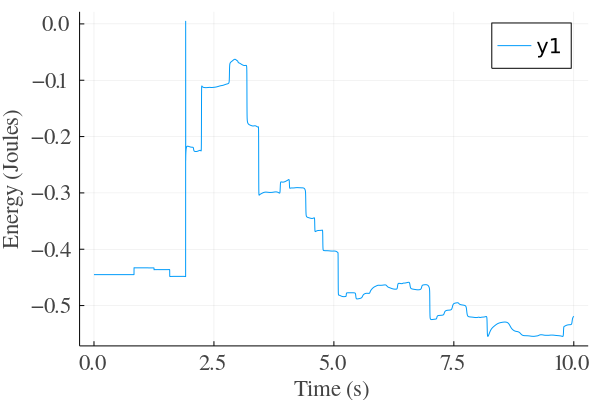

In [22]:
#Plot total energy
using Plots
fnt = Plots.font("Times Roman")

E = zeros(N)
for k = 1:N
    E[k] = H(xtraj[:, k])
end

p1 = plot(thist,E, xlabel="Time (s)", ylabel="Energy (Joules)", 
    titlefont=fnt, guidefont=fnt, tickfont=fnt, legendfont=fnt, fmt = :png)